# NYC Taxi Fare Prediction

## --Work in progress--

##### Kaggle Blurb
In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of 5-8 dollars, depending on the model used.

##### My Approach
While there are plenty of submissions and Medium articles on this particular problem, I'm going to take a bit of a different approach.

Taxi fares in most towns and small cities are a direct function of time spent driving. NYC is a different beast. Depending on time of day, destination, speed of traffic etc, fares are surcharged at additional per minute rates and flat rates. I'm going to see if building a model that significantly improves on Google's baseline error can be achieved by stripping fares of their surcharges, making predictions using a highly conservative set of features, and using a rules-based function to add surcharges to predictions. I'll then compare that approach to one which ingests surcharge rules as features rather than in post-processing. 

In [1]:
# Module imports
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The raw dataset is on the order of 60m rows, far too many to process locally on this Macbook. Reading some other approaches to the problem, 2m rows has been getting good results so I'll start with that. 

In [2]:
filepath = r''
fares_train = pd.read_csv(filepath + 'train.csv', nrows=250000)

In [3]:
fares_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
# Need to cast the datetime column as a datetime
fares_train['pickup_datetime'] = pd.to_datetime(fares_train.pickup_datetime)

Normally we'd want to do some high level analysis of the data. Since we've been given a baseline reange already however, I'm going to create a rudimentary model to set a working baseline for this workflow then get into building on this. For this initial model I'm only going to wrangle the data so far as to create clean inputs. 

First, the data cleansing and creating the key distance travelled feature. For that I'll use the Haversine formula.

In [5]:
# Checking for nulls
print(fares_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    2
dropoff_latitude     2
passenger_count      0
dtype: int64


In [6]:
# There are null values in the dropoff columns so we'll just drop those rows
fares_train = fares_train.dropna()

In [7]:
print(fares_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


For fare amount, the values need to be sanity checked. Intuitively, the fare cannot be less than 0. Furthermore, every taxi trip in NYC has a base fare of 2.50, so anything below that will be considered bad data. Outputting the min and max fare values below shows that values exist outside of those constraints. There's also a singular huge outlier. We can set a rule that training fares should be below 1000 dollars, which will generalize well to other subsets of data since we're only using 10% of the training set provided right now. 

In [8]:
print(fares_train.fare_amount.min(), fares_train.fare_amount.max())
print(fares_train.fare_amount.sort_values(ascending=False)[:10].tolist())

-44.9 500.0
[500.0, 495.0, 450.0, 281.05, 255.0, 245.41, 240.0, 235.0, 225.0, 217.0]


In [9]:
# Constraining fares to real world values
fares_train = fares_train.loc[(fares_train.fare_amount >= 2.5) & (fares_train.fare_amount < 1000)]

Similarly for passenger count, the data must represent real world values. According to the NYC Taxi & Limousine Commission, the largest vehicle (by seats) eligible for a medallion is the Nissan NV200 passenger van with 12 seats. The Ford Transit Connect is also on the list, but only wheelchair accesible versions which are limited to 6 seats. 

Allowed vehicle source: https://www1.nyc.gov/site/tlc/about/vehicles-in-use-approved-vehicle-list.page

Seating data sourced from vehicle manufacturer websites. 

The passenger count data will, as such, be constrained to 1 >= n <= 12  

In [10]:
fares_train = fares_train.loc[(fares_train.passenger_count >= 1) & (fares_train.passenger_count <= 12)]
print(fares_train.passenger_count.min(), fares_train.passenger_count.max())

1 6


The geospatial data needs to make real world sense too. Since the project is limited to NYC, any lat/longs unreasonably far from NYC need to be removed. Checking rounded values in the pickup_longitude column reveals a significant number of values that are clearly errounous.

In [11]:
fares_train['pickup_longitude'].astype(int).unique()

array([ -73,  -74,    0,   40,  -72,  -75,   -1,  -70, -736,  -78,   -7,
        -69, 2140,  -10,  -76,  -71, -121, -740], dtype=int64)

The rough lat/long of lower Manhattan is 41.71N, 74W. One degree of latitude is roughly 69 miles. Anything drastically different is definitely errounous, and any legitimate journey of greater than around one degree is an outlier and will bias the model. As such, it only makes sense to keep data within a couple of degrees of the city, so we can set the latitudinal bounds as 40N and 43N, and the longitudinal bounds as 73W and 75W.

In [12]:
fares_train = fares_train.loc[((fares_train.pickup_latitude >= 40) & (fares_train.pickup_latitude <= 43)) &
                              ((fares_train.dropoff_latitude >= 40) & (fares_train.dropoff_latitude <= 43)) &
                              ((fares_train.pickup_longitude <= -73) & (fares_train.pickup_longitude >= -75)) &
                              ((fares_train.dropoff_longitude <= -73) & (fares_train.dropoff_longitude >= -75))]

Now I'll build the distance travelled feature implementing a function using the Haversine formula. There's also an opportunity do an a additional bit of cleaning here by ensuring distances are all > 0. 

In [13]:
fares_train['pickup_coords'] = list(zip(fares_train.pickup_latitude, fares_train.pickup_longitude))
fares_train['dropoff_coords'] = list(zip(fares_train.dropoff_latitude, fares_train.dropoff_longitude))
fares_train.drop(['pickup_longitude', 
                  'pickup_latitude', 
                  'dropoff_longitude', 
                  'dropoff_latitude'],
                 axis=1,
                 inplace=True)

In [14]:
def calculate_distance(row):
    
    from math import radians, cos, sin, asin, sqrt
    
    lat1 = row.pickup_coords[0]
    lon1 = row.pickup_coords[1]
    lat2 = row.dropoff_coords[0]
    lon2 = row.dropoff_coords[1]

    R = 6372.8 # using km as unit of measure

    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return R * c
    

fares_train['dist'] = fares_train.apply(calculate_distance, axis=1)

fares_train = fares_train.loc[fares_train.dist > 0]

Now to get onto making the appropriate features ML ready. For this first iteration, only distance travelled will be used as the training feature, to make sure we're in the ballpark given by the blurb from kaggle. Similarly, a simple linear regression will suffice just fine. 

This time round, data won't be normalized, but will be required with additional feature engineering.

In [15]:
def linear_model(data, training_cols, target):

    X, y = data[training_cols], data[target]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    from sklearn.linear_model import LinearRegression 
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
    
    
linear_model(data=fares_train, training_cols=['dist'], target='fare_amount')

RMSE: 5.344616871316649


This is good stuff. The RMSE falls within the 5-8 range targeted even with a small sample of the overall dataset, so the model build is definitely on the right track. 

Only distance travelled was used to train that initial model. For NYC taxis, a fairly complex fare system exists. The full set of rules can be found here: https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

Coding everything there would be extremely time consuming and mostly for not much benefit, so parsing out the most common/impactful ones will be the most productive strategy. What are those?
- 2.50 base charge on every fare. 
- 1.00 surcharge between the hours of 4pm and 8pm on weekdays, excluding holidays. 
- 0.50 overnight surcharge between hours of 8pm and 6am. 
- 0.30 Improvement surcharges to every fare. 
- 2.50/2.75/0.75 charge for all trips beginning south of 96th St depending on ride type. 
- Hudson River crossings and some East River crossings have tolls. 
- Trips to/from JFK have a flat rate of 52.00 with a 4.50 surcharge between 4pm and 8pm excluding holidays. 
- Trips to EWR have a 17.50 surcharge. 

As I mentioned in the initial blurb, creating an adjusted fare feature to isolate the fare for distance travelled minus fees will be a more accurate representation of the relationship between distance travelled and fare paid. 

In [16]:
# To create the adjusted fare the surcharges need to be removed from the actual charge to the passenger
def adjust_fare_paid(row):
    
    af = row.fare_amount # af: adjusted fare
    ride_datetime = row.pickup_datetime
    
    trip_time = ride_datetime.time()
    trip_day = ride_datetime.isoweekday() # Mon = 1, Sun = 7
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    eight_pm_ts = dt.datetime.strptime('20:00', '%H:%M').time()
    six_am_ts = dt.datetime.strptime('06:00', '%H:%M').time()
    four_pm_ts = dt.datetime.strptime('16:00', '%H:%M').time()
    
    # Base fare
    af -= 2.50 # accounts for base fare
    
    # Evening rush hour surcharge
    if trip_time > four_pm_ts and trip_time < eight_pm_ts and trip_day <= 5:
        af -= 1
    else: 
        pass
    
    # Overnight surcharge
    if trip_time > eight_pm_ts or trip_time < six_am_ts:
        af -= 0.5
    else: 
        pass    
    
    # Improvement surcharge
    af -= 0.3
    
    # Trips below 96th
    # South and west of the east end of 96th St
    # Some accuracy lost as 96th runs NW but tradeoff is no falsely assigned surcharges
    if pu_coords[0] < 40.782799 and pu_coords[1] > -73.936949:
        af -= 2.50
    
    # Bridge tolls
    # All bridges across the east river between Queens/Bronx/Upper Manhattan have an $8.50 toll
    # Note, bridges south of Randalls Island have no tolls, and we'll have to take an accuacy hit for the Midtown tunnel
    # Without having to use intensive geospatial code, we can approximate trips that crossed those northern bridges
    # The coords (40.795268, -73.928113) are near Randalls Island, in between Queens, the Bronx, and Harlem
    # The majority of the Bronx is east and north, majority of Queens is east and south, upper Manhattan is west and north
    # Trips that start/end east of that point and crossed the latitude used one of the bridges
    # Trips that start/end west of the point and cross E/W AND N/S crossed the Triborough bridge
    # Manhattan - Queens trips
    if pu_coords[0] > 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] < 40.795268 and do_coords[1] > -73.928113:
        af -= 8.50
    # Queens - Manhattan trips
    elif pu_coords[0] < 40.795268 and pu_coords[1] > -73.928113 and do_coords[0] > 40.795268 and do_coords[1] < -73.928113:
        af -= 8.50
    # Bronx - Queens trips
    elif pu_coords[0] > 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] < 40.795268 and do_coords[1] < -73.928113:
        af -= 8.50
    # Queens - Bronx trips
    elif pu_coords[0] < 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] > 40.795268 and do_coords[1] < -73.928113:
        af -= 8.50
    else:
        pass

    
    return af


fares_train['adjusted_fare'] = fares_train.apply(adjust_fare_paid, axis=1)

On top of surcharges and bridge tolls, airport rides are a significant contributor to the dataset. Let's visualize what dropoffs look like across the dataset. 

(40.625, 40.873)

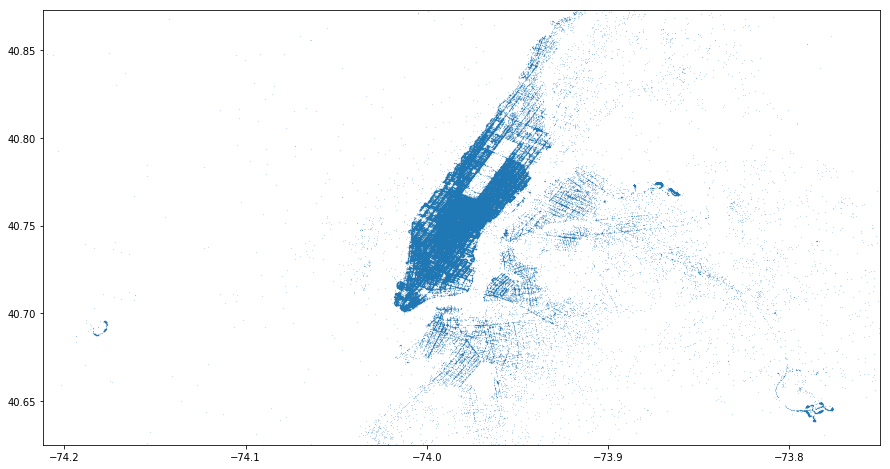

In [17]:
do_lats = [i[0] for i in fares_train.dropoff_coords.tolist()]
do_lons = [i[1] for i in fares_train.dropoff_coords.tolist()]

fig = plt.figure(figsize=(15,8))
plt.scatter(x=do_lons, y=do_lats, s=0.008)
plt.xlim((-74.211938, -73.75))
plt.ylim((40.625, 40.873))

We can see from the visualization that all three airport are clearly defined, meaning a lot of trips for each. For those unfamiliar with the city's geography, the relevant clustered points are JFK on the bottom right, LGA center right, EWR on the far left. LGA has no special fare rules so doesn't need to be accounted for. JFK and EWR do, though. 

JFK has a flat rate fare, so it makes sense to assign a boolean categorical feature to runs that start or end there. EWR has a surcharge on top of a standard metered fare so an adjustment to our adjusted fare feature is more appropriate. 

In [18]:
# JFK trips
def is_jfk_trip(row):
    
    # NW 40.661947, -73.808848
    # NE 40.653712, -73.771211
    # SW 40.641392, -73.807694
    # SE 40.639457, -73.761142
    # Center point 40.645925, -73.785512, 3kft lat 40.655189, 3kft lon -73.762359
    ctr_lat = 40.645925
    ctr_lon = -73.785512
    
    ride_datetime = row.pickup_datetime
    
    trip_time = ride_datetime.time()
    trip_day = ride_datetime.isoweekday() # Mon = 1, Sun = 7
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    eight_pm_ts = dt.datetime.strptime('20:00', '%H:%M').time()
    four_pm_ts = dt.datetime.strptime('16:00', '%H:%M').time()
    
    # Using np.abs we can check if pickup/dropoff falls within ~3000ft of the center point of the airport
    # This encompasses all airline terminals
    is_jfk_bool = False
    if np.abs(pu_coords[0] - ctr_lat) < 0.015 and np.abs(pu_coords[1] - ctr_lon) < 0.025:
        is_jfk_bool = True
    elif np.abs(do_coords[0] - ctr_lat) < 0.015 and np.abs(do_coords[1] - ctr_lon) < 0.025:
        is_jfk_bool = True
    else:
        pass
    
    if is_jfk_bool == True:
        # JFK has an extra surcharge of 4.50 for rush hour trips. 1.00 was already accounted for in the earlier fare adjustment
        if trip_time >= four_pm_ts and trip_time < eight_pm_ts and trip_day <= 5:
            row.adjusted_fare -= 3.50
        return 1
    else:
        return 0
    
fares_train['is_jfk_trip'] = fares_train.apply(is_jfk_trip, axis=1)

In [19]:
# EWR trips
# Trips TO EWR have a standard metered fare plus a 17.50 surcharge
def is_ewr_trip(row):
    
    ctr_lat = 40.691946
    ctr_lon = -74.180670
    do_coords = row.dropoff_coords
    output_adjusted_fare = row.adjusted_fare
    
    # Only need to account for dropoffs
    if np.abs(do_coords[0] - ctr_lat) < 0.015 and np.abs(do_coords[1] - ctr_lon) < 0.025:
        row.adjusted_fare -= 17.50
        return 1 
    else:
        return 0
    
fares_train['is_ewr_trip'] = fares_train.apply(is_ewr_trip, axis=1)

Once again, we need to sanity check the data. After the surcharge/toll/airport processing, let's check how it's affected the data.

In [20]:
print('% fares below 0:', (len(fares_train.loc[fares_train.adjusted_fare < 0]) / (len(fares_train)))*100)
print('JFK trips:', len(fares_train.loc[fares_train.is_jfk_trip == 1]))
print('Mean fare adjustment:', np.mean(fares_train.fare_amount - fares_train.adjusted_fare))

% fares below 0: 3.6083905649663657
JFK trips: 5136
Mean fare adjustment: 3.6634709517654205


A small percentage of fares have been adjusted to be below 0 dollars, however the mean fare adjustment is close to surcharges the majority of "not-special" rides would have (i.e. no tolls or airports). The values below zero are almost certainly victims of the geospatial assumptions, so we need to lose them. It's small amount of data loss for gaining a far more accurate representation of the fare to distance relationship. 

In [21]:
fares_train = fares_train.loc[fares_train.adjusted_fare > 0]

### In-Depth Model Analysis

Now we've got a real handle on the data, and coded some functions to account for special cases of taxi fares. Now we need to evaluate how effective adding various combinations of these features affects model performance. 

Since the baseline model used was linear regression, I'll continue using that to allow the comparison. With the addition of the new (mostly boolean) features, the problem also lends itself to a tree model. I'll use a random forest model as a comparison to the linear regression to see how far below baseline error we can get. 

Now to run the linear regression function we created earlier using adjusted fare as the target instead of the original fare listed.

In [22]:
linear_model(fares_train, ['dist'], 'adjusted_fare')

RMSE: 5.759735849584241


Error has improved around 30 cents from just improving the accuracy of the fare. Since the model function was built to accept a list of columns as the training cols, we can also utilize the categorical features we created for JFK and EWR trips as well as passenger count. 

In [23]:
linear_model(fares_train, ['dist', 'is_jfk_trip', 'is_ewr_trip', 'passenger_count'], 'adjusted_fare')

RMSE: 5.518580505492098


So roughly a 5 cent improvement by adding those extra features. 

- A couple of easy features to add are also evident. 
    - Taxi fares cost more sitting in traffic. We haven't accounted for rush hour congestion around popular spots. 
    - From the map created above, three standout choke points we haven't accounted for are LGA airport, Midtown, and FiDi. 
    - Note: LGA fares are not surcharged. 
- Values based on time would also be helpful. E.g. day of week and perhaps an is_rush_hour categorical feature. 

We'll create those now. 

In [24]:
# LGA airport 
def is_lga_trip(row):
        
    ctr_lat = 40.774120
    ctr_lon = -73.868192
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    if np.abs(do_coords[0] - ctr_lat) < 0.01 and np.abs(do_coords[1] - ctr_lon) < 0.015:
        return 1 
    elif np.abs(pu_coords[0] - ctr_lat) < 0.01 and np.abs(pu_coords[1] - ctr_lon) < 0.015:
        return 1
    else:
        return 0
    
    
fares_train['is_lga_trip'] = fares_train.apply(is_lga_trip, axis=1)

In [25]:
# Midtown
def is_midtown_trip(row):
        
    ctr_lat = 40.761589
    ctr_lon = -73.981435
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    if np.abs(do_coords[0] - ctr_lat) < 0.02 and np.abs(do_coords[1] - ctr_lon) < 0.02:
        return 1 
    elif np.abs(pu_coords[0] - ctr_lat) < 0.02 and np.abs(pu_coords[1] - ctr_lon) < 0.02:
        return 1
    else:
        return 0
    
    
fares_train['is_midtown_trip'] = fares_train.apply(is_midtown_trip, axis=1)

In [26]:
# FiDi
def is_fidi_trip(row):
        
    ctr_lat = 40.714092
    ctr_lon = -73.981435
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    if np.abs(do_coords[0] - ctr_lat) < 0.15 and np.abs(do_coords[1] - ctr_lon) < 0.15:
        return 1 
    elif np.abs(pu_coords[0] - ctr_lat) < 0.15 and np.abs(pu_coords[1] - ctr_lon) < 0.15:
        return 1
    else:
        return 0
    
    
fares_train['is_fidi_trip'] = fares_train.apply(is_fidi_trip, axis=1)

In [27]:
# Weekday categorical
def is_weekday(row):
    
    trip_day = row.pickup_datetime.isoweekday() # Mon = 1, Sun = 7
    
    if trip_day <= 5:
        return 1
    else:
        return 0


fares_train['is_weekday'] = fares_train.apply(is_weekday, axis=1)

In [28]:
# Weekday rush categorical
def is_weekday_rush(row):
    
    ride_datetime = row.pickup_datetime
    trip_time = ride_datetime.time()
    trip_day = ride_datetime.isoweekday() # Mon = 1, Sun = 7
    
    eight_pm_ts = dt.datetime.strptime('20:00', '%H:%M').time()
    four_pm_ts = dt.datetime.strptime('16:00', '%H:%M').time()
    
    if trip_time >= four_pm_ts and trip_time < eight_pm_ts and trip_day <= 5:
        return 1
    else:
        return 0
    

fares_train['is_weekday_rush'] = fares_train.apply(is_weekday_rush, axis=1)

Training on an adjusted fare is no use if we can adjust the predicted fare to what it should with surcharges. We need a function to apply charges back to fares where needed. 

In [29]:
# Using the fare adjustment function from earlier, we can switch some things back around
def apply_approriate_charges(row):
    
    pf = row.predicted_adj_fare
    
    ride_datetime = row.pickup_datetime
    
    trip_time = ride_datetime.time()
    trip_day = ride_datetime.isoweekday() # Mon = 1, Sun = 7
    pu_coords = row.pickup_coords
    do_coords = row.dropoff_coords
    
    eight_pm_ts = dt.datetime.strptime('20:00', '%H:%M').time()
    six_am_ts = dt.datetime.strptime('06:00', '%H:%M').time()
    four_pm_ts = dt.datetime.strptime('16:00', '%H:%M').time()
    
    # Base fare
    pf += 2.50 # accounts for base fare
    
    # Evening rush hour surcharge
    if trip_time > four_pm_ts and trip_time < eight_pm_ts and trip_day <= 5:
        pf += 1
    else: 
        pass
    
    # Overnight surcharge
    if trip_time > eight_pm_ts or trip_time < six_am_ts:
        pf += 0.5
    else: 
        pass    
    
    # Improvement surcharge
    pf += 0.3
    
    # Trips below 96th
    # South and west of the east end of 96th St
    # Some accuracy lost as 96th runs NW but tradeoff is no falsely assigned surcharges
    if pu_coords[0] < 40.782799 and pu_coords[1] > -73.936949:
        pf += 2.50
    
    # Bridge tolls
    # All bridges across the east river between Queens/Bronx/Upper Manhattan have an $8.50 toll
    # Note, bridges south of Randalls Island have no tolls, and we'll have to take an accuacy hit for the Midtown tunnel
    # Without having to use intensive geospatial code, we can approximate trips that crossed those northern bridges
    # The coords (40.795268, -73.928113) are near Randalls Island, in between Queens, the Bronx, and Harlem
    # The majority of the Bronx is east and north, majority of Queens is east and south, upper Manhattan is west and north
    # Trips that start/end east of that point and crossed the latitude used one of the bridges
    # Trips that start/end west of the point and cross E/W AND N/S crossed the Triborough bridge
    # Manhattan - Queens trips
    if pu_coords[0] > 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] < 40.795268 and do_coords[1] > -73.928113:
        pf -= 8.50
    # Queens - Manhattan trips
    elif pu_coords[0] < 40.795268 and pu_coords[1] > -73.928113 and do_coords[0] > 40.795268 and do_coords[1] < -73.928113:
        pf -= 8.50
    # Bronx - Queens trips
    elif pu_coords[0] > 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] < 40.795268 and do_coords[1] < -73.928113:
        pf -= 8.50
    # Queens - Bronx trips
    elif pu_coords[0] < 40.795268 and pu_coords[1] < -73.928113 and do_coords[0] > 40.795268 and do_coords[1] < -73.928113:
        pf -= 8.50
    else:
        pass
    
    # EWR surcharge
    ewr_lat = 40.691946
    ewr_lon = -74.180670
    do_coords = row.dropoff_coords
    
    # Only need to account for dropoffs
    if np.abs(do_coords[0] - ewr_lat) < 0.015 and np.abs(do_coords[1] - ewr_lon) < 0.025:
        pf += 17.50
    
    return pf

No we have all the rules-based functions ready, we should check the RMSE improvement with these new features. There are six distinct sets of constraints to train the data on at this point:
- Estimating full fare using distance alone.
- Estimating full fare using additional features. 
- Estimating adjusted fare using distance alone, then adding surcharges. 
- Estimating adjusted fare using additional features, then adding surcharges. 

Since  surcharges needs to be baked 

I'll create two arrays of training columns and run the linear model for each of the above scenarios. We did already run the model for full fare w/ distance alone earlier but will run it again here for easy comparison. 

In [30]:
multivariate_training = ['dist', 
                        'is_jfk_trip', 
                        'is_ewr_trip', 
                        'is_lga_trip', 
                        'is_midtown_trip', 
                        'is_fidi_trip', 
                        'passenger_count',
                        'is_weekday',
                        'is_weekday_rush']
univariate_training = ['dist']

Of course the adjusted fare is not the actual fare we need to predict, we need to be able to add back the surcharges to our models predictions. The final RMSE for our baseline linear model should be modelled adjusted fare + appropriate charges scored against the actual fare paid. 

We'll apply the apply_appropriate_charges function inside a modified version of the linear_model function we already built. 

In [31]:
def linear_model_adjusted(data, training_cols, target):
    
    X, y = data[training_cols], data[target]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    from sklearn.linear_model import LinearRegression
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Applying surcharges to predictions and testing error
    charges_applied_data = data.copy() 
    charges_applied_data['predicted_adj_fare'] = model.predict(charges_applied_data[training_cols])
    charges_applied_data['fare_with_charges'] = charges_applied_data.apply(apply_approriate_charges, axis=1)
    y_true_full_fare = charges_applied_data.fare_amount
    y_pred_full_fare = charges_applied_data.fare_with_charges
    
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_true_full_fare, y_pred_full_fare)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)

In [33]:
# Full fare using only distance
print('Full fare, distance only:')
linear_model(fares_train, univariate_training, 'fare_amount')

# Full fare using additional features
print('Full fare, all features:')
linear_model(fares_train, multivariate_training, 'fare_amount')

# Adjusted fare using only distance
print('Adjusted fare, distance only:')
linear_model_adjusted(fares_train, univariate_training, 'adjusted_fare')

# Adjusted fare using additional features
print('Adjusted fare, all features:')
linear_model_adjusted(fares_train, multivariate_training, 'adjusted_fare')

Full fare, distance only:
RMSE: 5.650319520071359
Full fare, all features:
RMSE: 5.1875414180360515
Adjusted fare, distance only:
RMSE: 5.682771505770222
Adjusted fare, all features:
RMSE: 5.5471332305821885


Now taking the exact linear regression function from earlier, we can add in the real fare adjustment.

Using surcharge agnostic fare predictions and adding surcharges later has knocked another 10 cents off the error score. Since this is still a Linear Regression as we've been using all along, we can test this workflow with a more complex model. 

A score under 5 will be good, as it'll be beating the the range initially set for a basic distance to fare model. Trying a few models (including GradientBoostingRegressor) reveals that the best full fare RMSE is the RandomForestRegressor.

In [ ]:
def rf_reg_model(data, training_cols, target):
    
    X, y = data[training_cols], data[target]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Adjusted fare RMSE:', rmse)
    
    # Applying surcharges to predictions and testing error
    charges_applied_data = data.copy() 
    charges_applied_data['adj_predicted_fare'] = model.predict(charges_applied_data[training_cols])
    charges_applied_data['fare_with_charges'] = charges_applied_data.apply(apply_approriate_charges, axis=1)
    new_mse = mean_squared_error(charges_applied_data.fare_amount, charges_applied_data.fare_with_charges)
    new_rmse = np.sqrt(new_mse)
    print('Charges Applied RMSE:', new_rmse)

rf_reg_model(fares_train, training_cols, 'adjusted_fare')

A couple of tests to conduct now with hyperparameter optimization. 